In [1]:
import cv2
import dlib
import numpy as np

from collections import OrderedDict
from imutils import face_utils
from matplotlib import pyplot as plt

In [2]:
def opencv2numpy(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

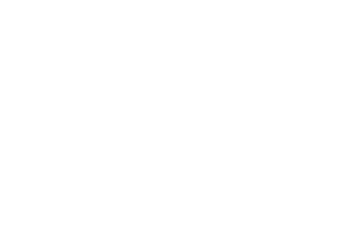

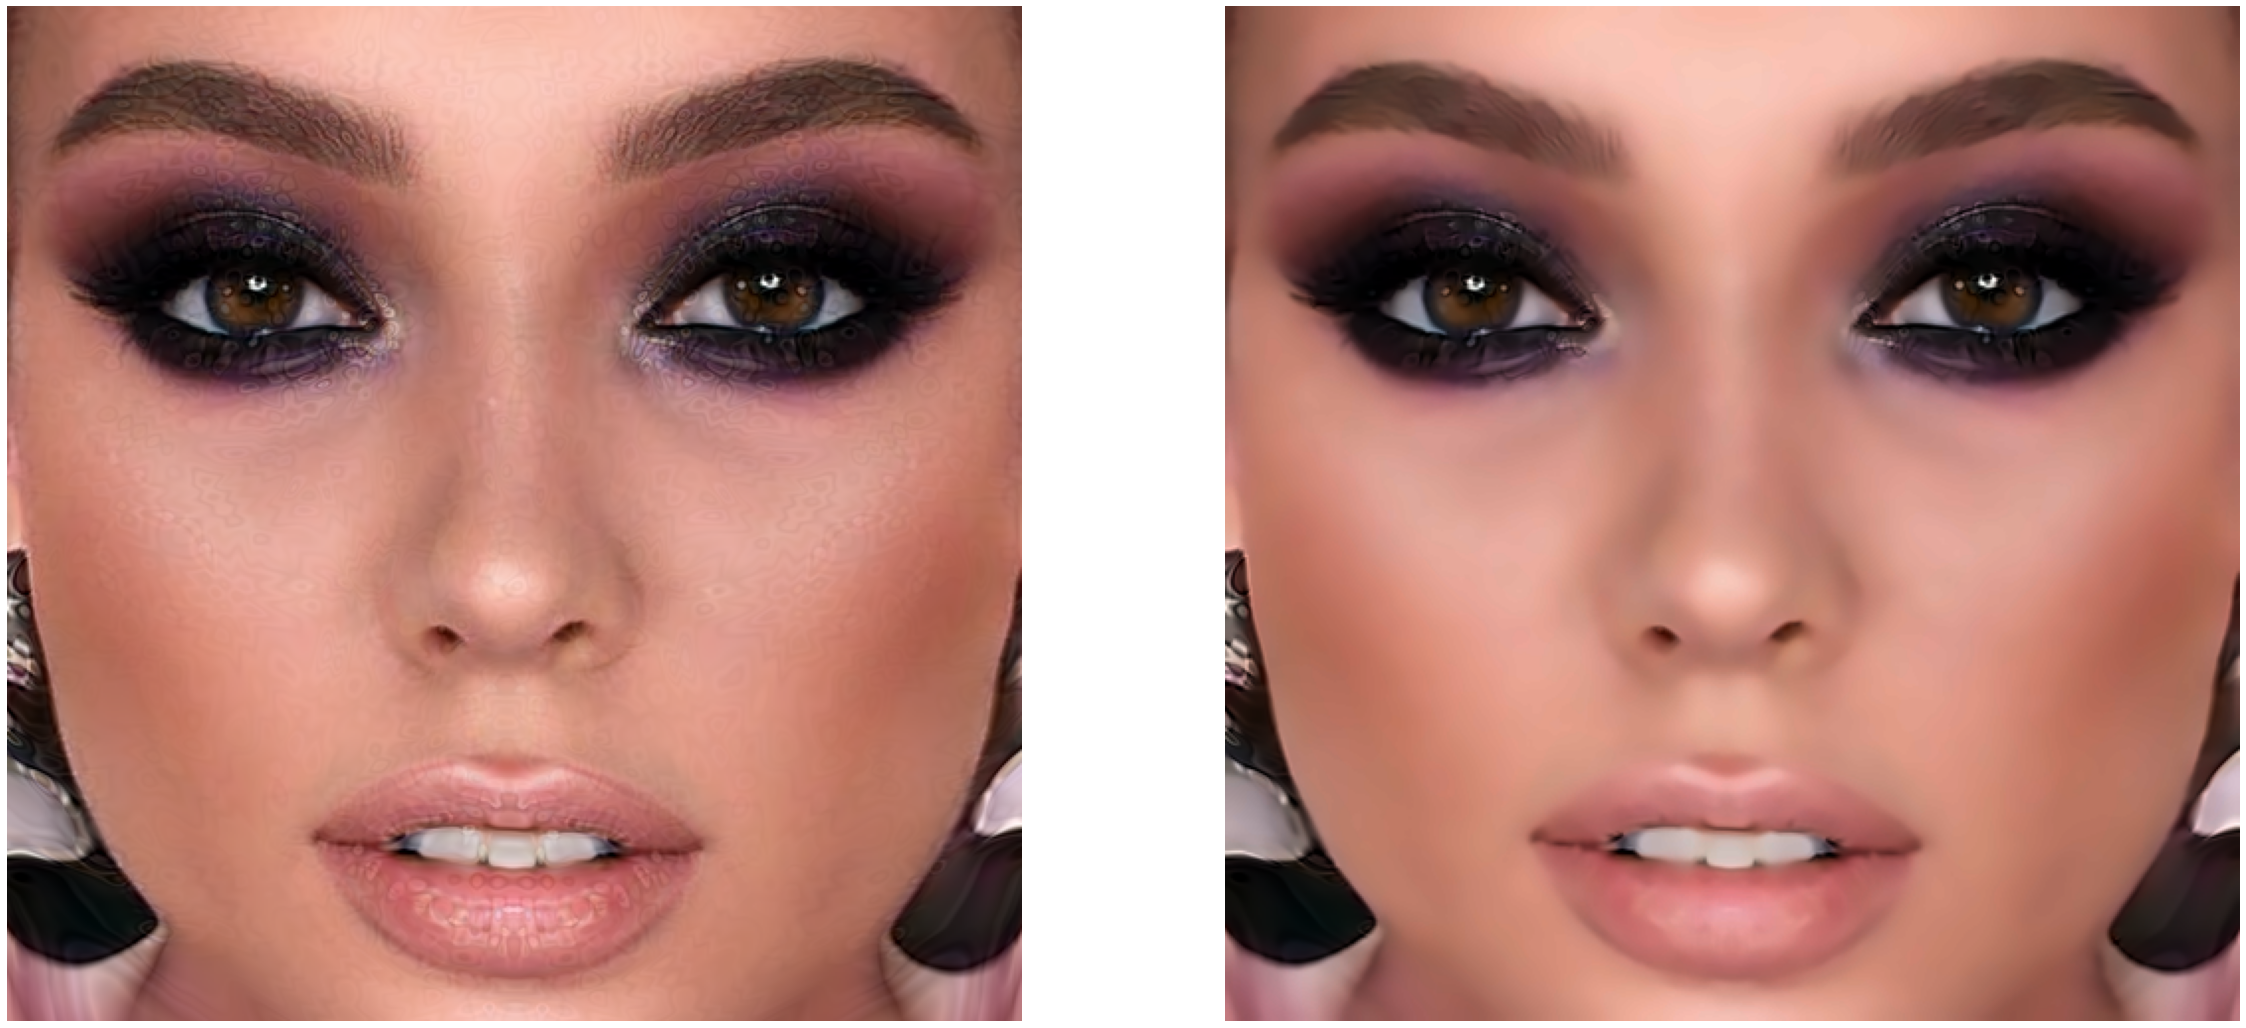

In [155]:

  
# Reading image from folder where it is stored
img = cv2.imread('../data/generated/seed0239.png', cv2.COLOR_RGB2BGR)


# src: Input 8-bit 3-channel image.
# 
# dst: Output image with the same size and type as src.
# 
# templateWindowSize: 
#   Size in pixels of the template patch that is used to compute weights. Should be odd. Recommended value 7 pixels
# 
# searchWindowSize:
#   Size in pixels of the window that is used to compute weighted average for given pixel. 
#   Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time. 
#   Recommended value 21 pixels
# 
# h: Parameter regulating filter strength for luminance component. 
#    Bigger h value perfectly removes noise but also removes image details, smaller h value preserves details but also preserves some noise
# 
# hColor: 
#   The same as h but for color components. 
#   For most images value equals 10 will be enough to remove colored noise and do not distort colors


# denoising of image saving it into dst image
dst = cv2.fastNlMeansDenoisingColored(
    src=img, 
    dst=None, 
    h=11, 
    hColor=5, 
    templateWindowSize=4, 
    searchWindowSize=10
)
  
# Plotting of source and destination image
plt.axis("off")
_, axes = plt.subplots(1, 2, figsize=(40, 40))
for ax in axes:
    ax.axis("off")
axes[0].imshow(opencv2numpy(img))
axes[1].imshow(opencv2numpy(dst))
  
plt.show()

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../segmentation/models/shape_predictor_68_face_landmarks.dat')

### Facial landmarks

 <img src="../info/landmarks68.png" alt="landmarks" width="500"/>

In [5]:
#For dlib’s 68-point facial landmark detector:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

In [52]:
def get_makeup_eye_box(
    shape, 
    eye_position, 
    size=512,
    x_padding=(0, 0),
    y_padding=(0, 0)
):
    eyebrow_min_index, eyebrow_max_index = FACIAL_LANDMARKS_68_IDXS[f'{eye_position}_eyebrow']
    eye_min_index, eye_max_index         = FACIAL_LANDMARKS_68_IDXS[f'{eye_position}_eye']
    
    left, top, right, bottom = size, size, 0, 0
    for i, (x, y) in enumerate(shape):
        if i in range(eyebrow_min_index, eyebrow_max_index):
            top  = max(
                min(top, y - y_padding[0]),
                0
            )
            left = max(
                min(left, x - x_padding[0]),
                0
            )
            right = min(
                max(right, x + x_padding[1]),
                size
            )
        
        if i in range(eye_min_index, eye_max_index):
            bottom = min(
                max(bottom, y + y_padding[1]),
                size
            )
            
    return (left, top), (right, bottom)

In [124]:
def detect_eyes(image, detector=detector, predictor=predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)
    face  = faces[0]
    shape = predictor(gray, face)
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(face)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    left_eye = FACIAL_LANDMARKS_68_IDXS['right_eye']

    left_eye_box  = get_makeup_eye_box(shape, 'left',  x_padding=(10, 0), y_padding=(-20, 30))
    right_eye_box = get_makeup_eye_box(shape, 'right', x_padding=(0, 10), y_padding=(-20, 30))
    
    copied = image.copy()
    cv2.rectangle(copied, left_eye_box[0],  left_eye_box[1],  (0, 255, 0), 2)
    cv2.rectangle(copied, right_eye_box[0], right_eye_box[1], (0, 255, 0), 2)
    
    return left_eye_box, right_eye_box, copied

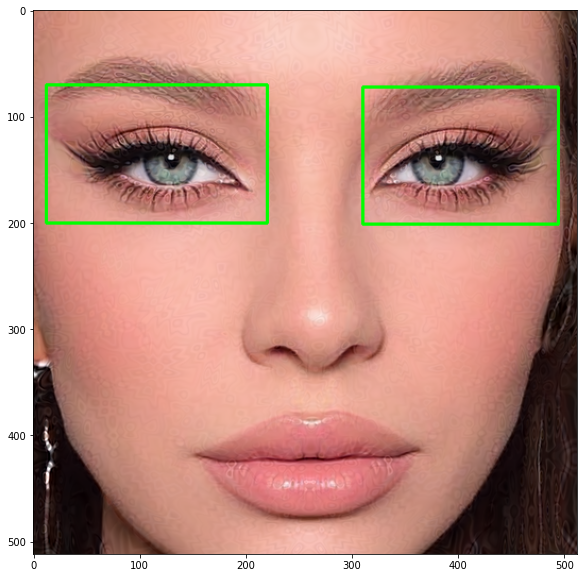

In [165]:
img = cv2.imread('../data/generated/seed0241.png', cv2.COLOR_RGB2BGR)
left_eye_box, right_eye_box, boxes_image = detect_eyes(img)
_ = plt.figure(figsize=(16, 10))
plt.imshow(opencv2numpy(boxes_image))

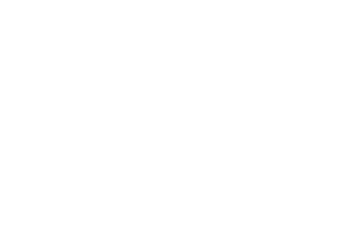

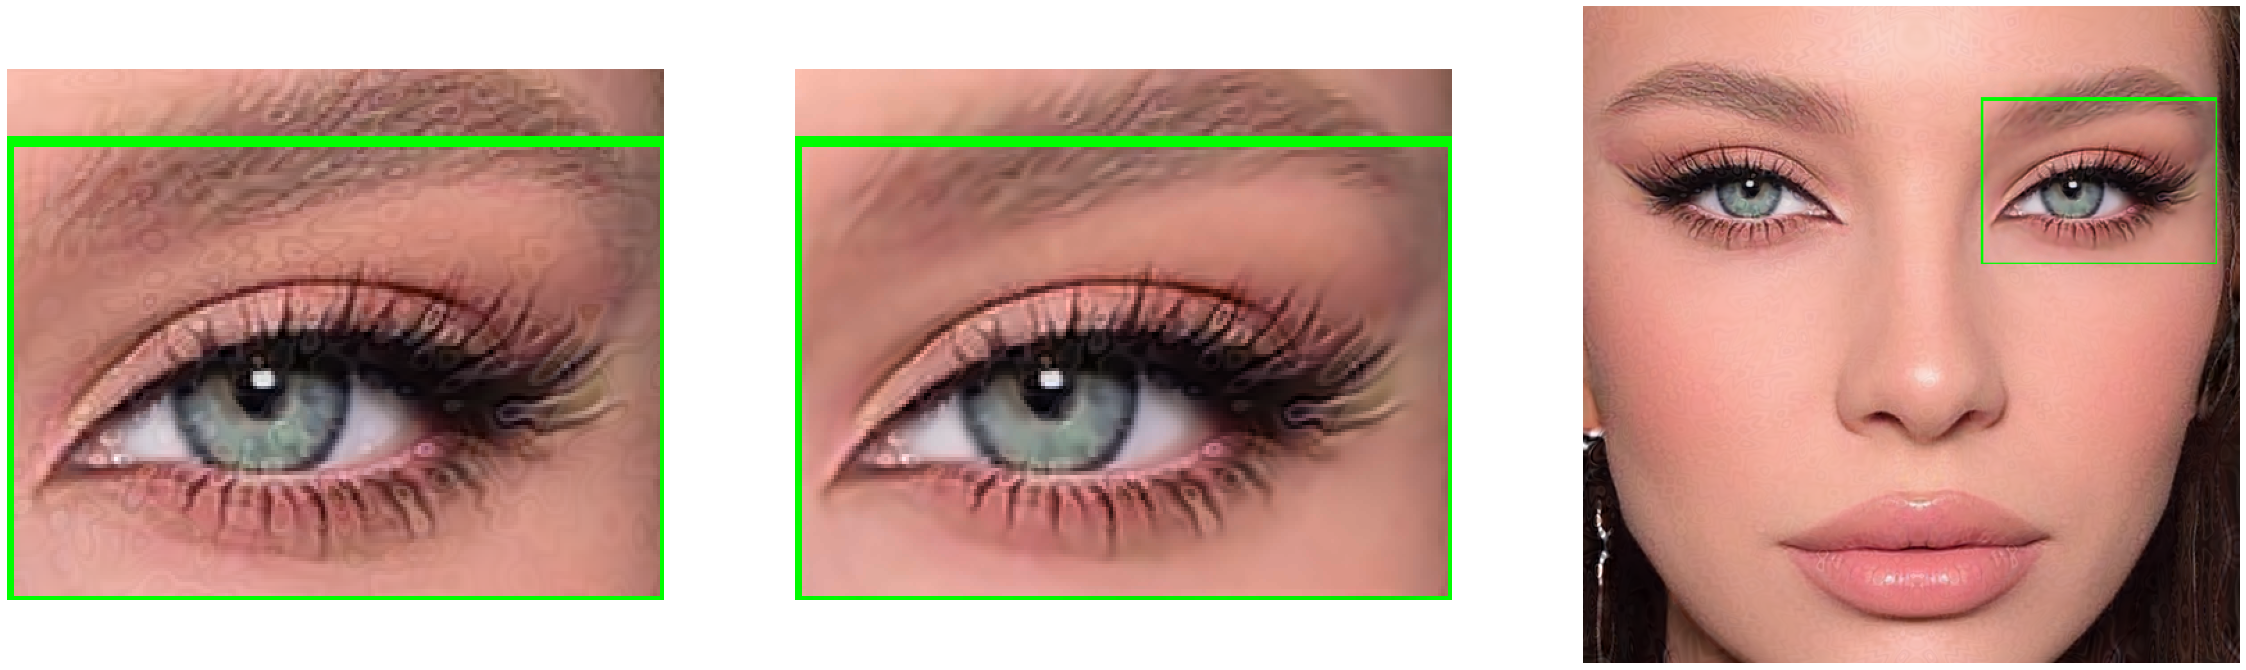

In [166]:
(x0, y0), (x1, y1) = left_eye_box

crop = boxes_image[y0 - 20 : y1, x0:x1]

dst = cv2.fastNlMeansDenoisingColored(
    src=crop, 
    dst=None, 
    h=7, 
    hColor=10, 
    templateWindowSize=7, 
    searchWindowSize=5
)

# Set filtered eye
img[y0-20:y1, x0:x1] = dst
  
# Plotting of source and destination image
plt.axis("off")
_, axes = plt.subplots(1, 3, figsize=(40, 40))
for ax in axes:
    ax.axis("off")
axes[0].imshow(opencv2numpy(crop))
axes[1].imshow(opencv2numpy(dst))
axes[2].imshow(opencv2numpy(img))
  
plt.show()